# The effects of Brexit

The aim of this notebook is to estimate the causal impact of Brexit upon the UK's GDP. This will be done using the {term}`synthetic control` approach. As such, it is similar to the policy brief "What can we know about the cost of Brexit so far?" {cite:p}`brexit2022policybrief` from the Center for European Reform. That approach did not use Bayesian estimation methods however.

I did not use the GDP data from the above report however as it had been scaled in some way that was hard for me to understand how it related to the absolute GDP figures. Instead, GDP data was obtained courtesy of Prof. Dooruj Rambaccussing. Raw data is in units of trillions of USD.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pymc_extras.prior import Prior

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = (
    cp.load_data("brexit")
    .assign(Time=lambda x: pd.to_datetime(x["Time"]))
    .set_index("Time")
    .loc[lambda x: x.index >= "2009-01-01"]
    # manual exclusion of some countries
    .drop(["Japan", "Italy", "US", "Spain", "Portugal"], axis=1)
)

# specify date of the Brexit vote announcement
treatment_time = pd.to_datetime("2016 June 24")

df.head()

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Iceland,Luxemburg,Netherlands,New_Zealand,Norway,Sweden,Switzerland,UK
Time,,,,,,,,,,,,,,,,
2009-01-01,3.84048,0.802836,0.94117,16.93824,4.50096,0.51052,5.05450,6.63471,5.18157,0.114836,1.634391,0.47336,7.78753,10.32220,1.476532,4.61881
2009-04-01,3.86954,0.796545,0.94162,16.75340,4.41372,0.50829,5.05375,6.64530,5.16171,0.116259,1.634432,0.47916,7.71903,10.32867,1.485509,4.60431
2009-07-01,3.88115,0.799937,0.95352,16.82878,4.42898,0.51299,5.06237,6.68237,5.24132,0.118747,1.640982,0.48188,7.72400,10.32328,1.502506,4.60722
2009-10-01,3.91028,0.803823,0.96117,17.02503,4.43300,0.50903,5.09832,6.73155,5.22482,0.119302,1.650866,0.48805,7.72812,10.37107,1.515139,4.62152
2010-01-01,3.92716,0.800510,0.96615,17.23041,4.47128,0.51413,5.11625,6.78621,4.91128,0.121414,1.647748,0.49349,7.87891,10.64833,1.525864,4.65380


In [4]:
# get useful country lists
target_country = "UK"
all_countries = df.columns
other_countries = all_countries.difference({target_country})
all_countries = list(all_countries)
other_countries = list(other_countries)

## Data visualization

In [5]:
az.style.use("arviz-white")

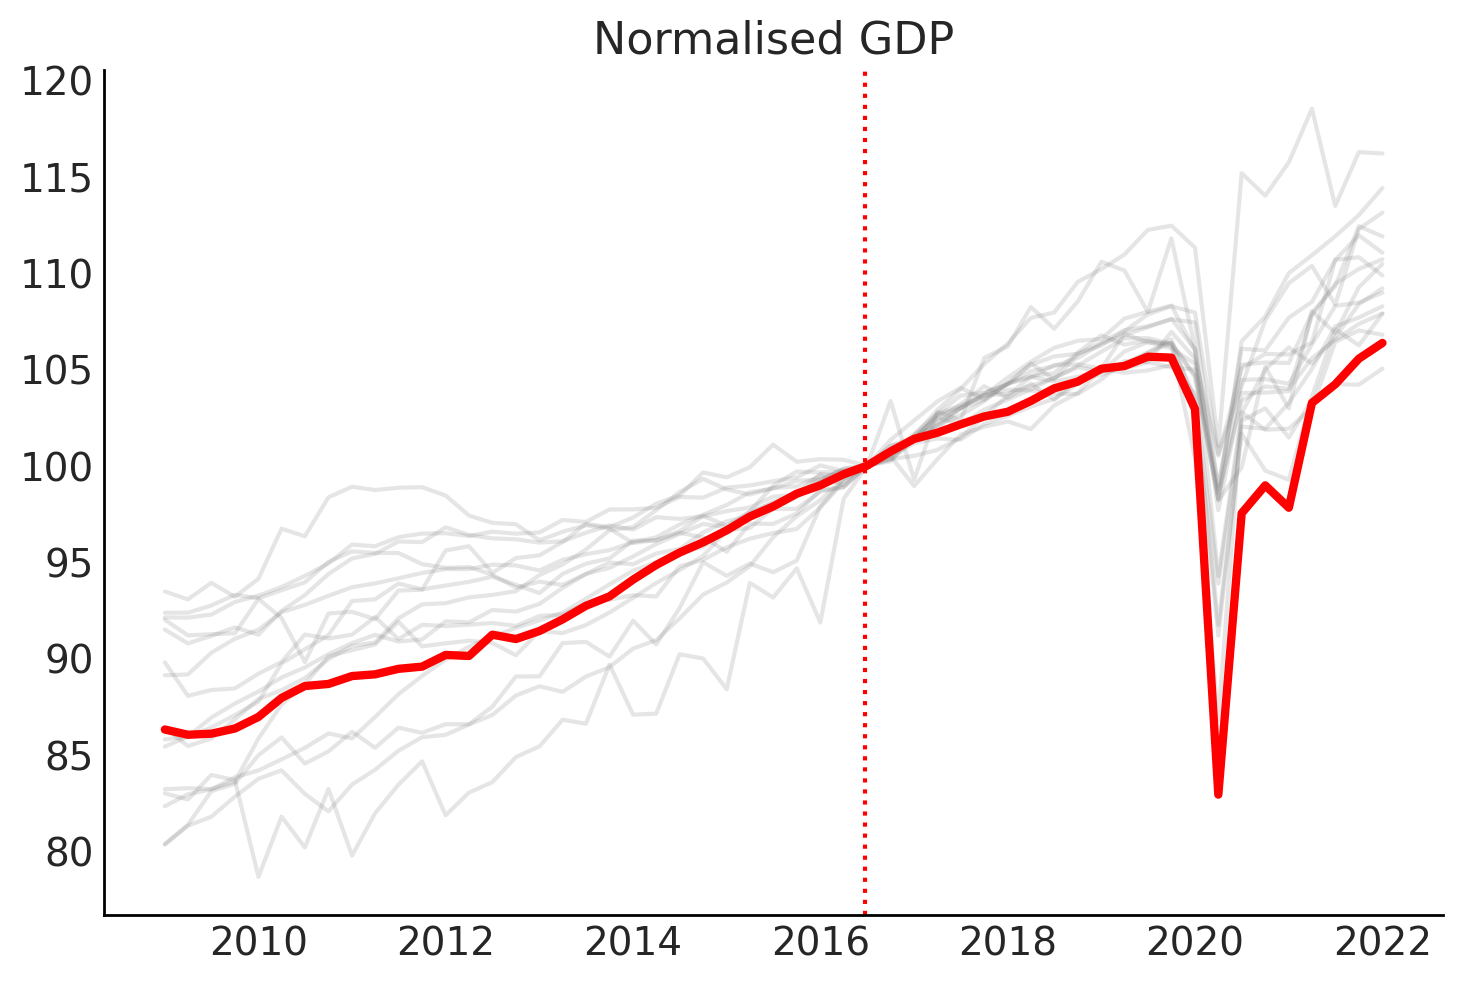

In [6]:
# Plot the time series normalised so that intervention point (Q3 2016) is equal to 100
gdp_at_intervention = df.loc[pd.to_datetime("2016 July 01"), :]
df_normalised = (df / gdp_at_intervention) * 100.0

# plot
fig, ax = plt.subplots()
for col in other_countries:
    ax.plot(df_normalised.index, df_normalised[col], color="grey", alpha=0.2)

ax.plot(df_normalised.index, df_normalised[target_country], color="red", lw=3)
# ax = df_normalised.plot(legend=False)

# formatting
ax.set(title="Normalised GDP")
ax.axvline(x=treatment_time, color="r", ls=":");

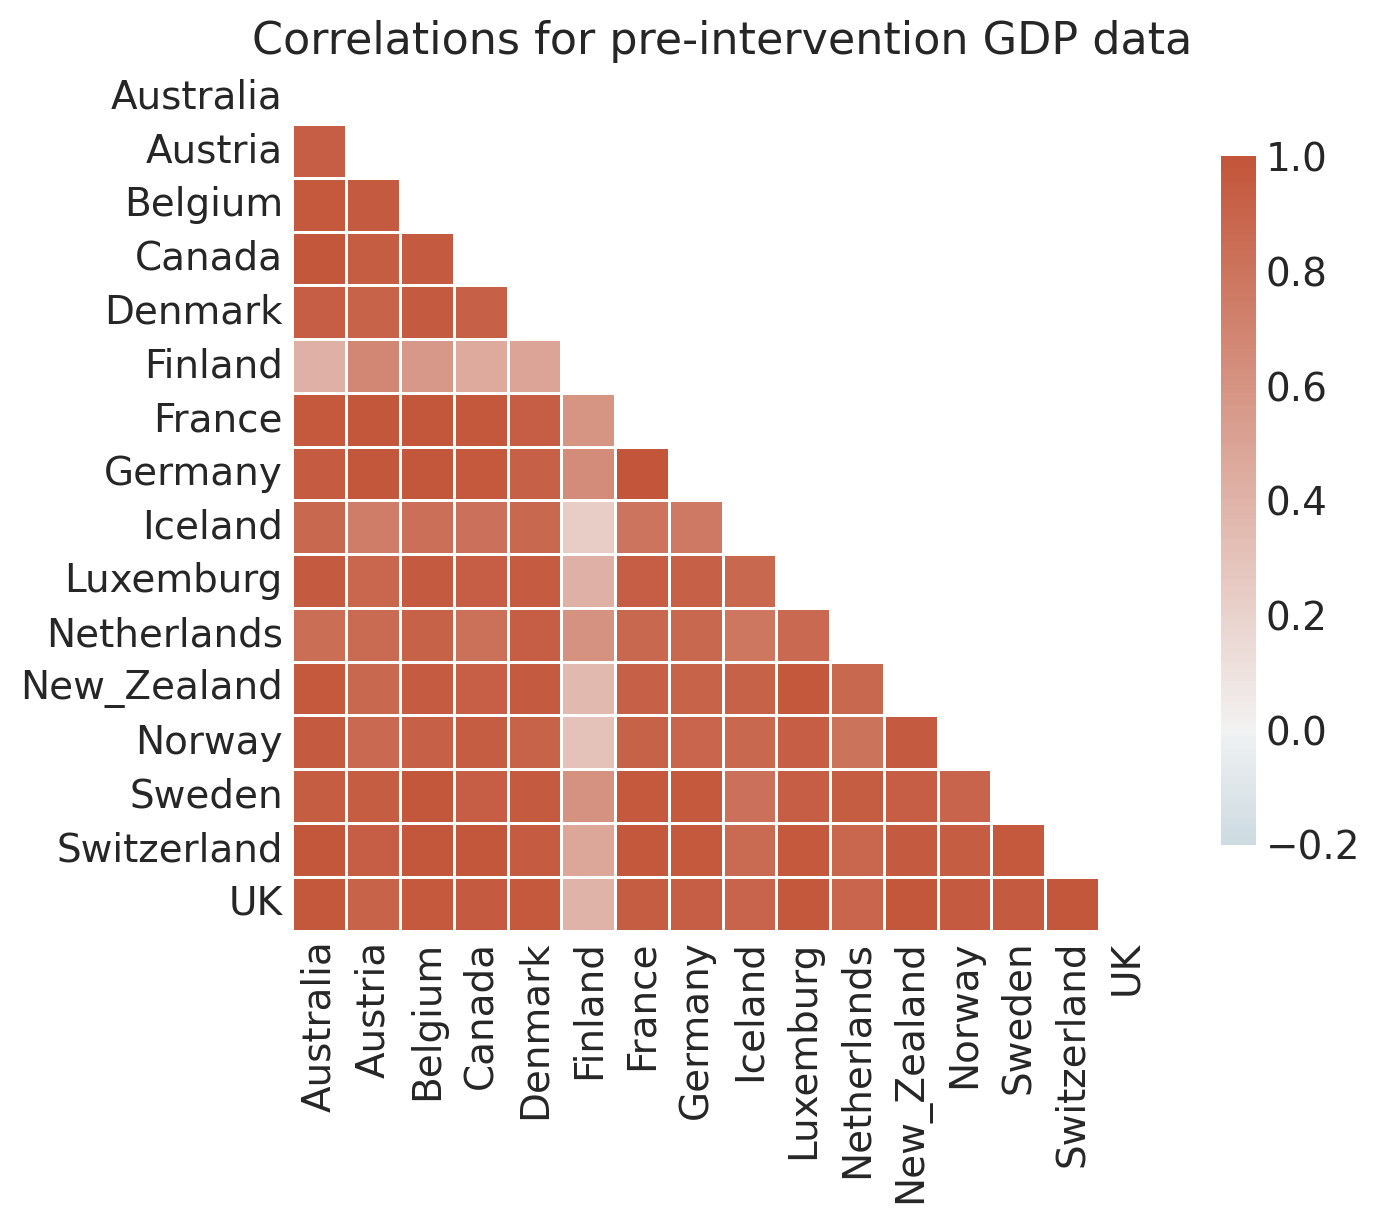

In [7]:
# Examine how correlated the pre-intervention time series are

pre_intervention_data = df.loc[df.index < treatment_time, :]

corr = pre_intervention_data.corr()

f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    cmap=sns.diverging_palette(230, 20, as_cmap=True),
    vmin=-0.2,
    vmax=1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
ax.set(title="Correlations for pre-intervention GDP data");

## Run the analysis

Note: The analysis is (and should be) run on the raw GDP data. We do not use the normalised data shown above which was just for ease of visualization.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [8]:
sample_kwargs = {"tune": 1000, "target_accept": 0.99, "random_seed": seed}

result = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=other_countries,
    treated_units=[target_country],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs=sample_kwargs,
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


While we are at it, let's plot the graphviz representation of the model. This shows us the inner workings of the `WeightedSumFitter` class which defines our synthetic control model with a sum to 1 constraint on the donor weights (here labelled as `coeffs`). This will be particularly useful when we come to exploring custom priors (see below).

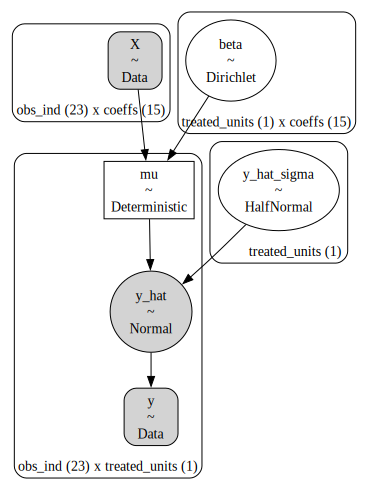

In [9]:
result.model.to_graphviz()

We currently get some divergences, but these are mostly dealt with by increasing `tune` and `target_accept` sampling parameters. Nevertheless, the sampling of this dataset/model combination feels a little brittle.

In [10]:
result.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Check the MCMC chain mixing via the `Rhat` statistic.

In [11]:
az.summary(result.idata, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[UK, Australia]",0.121,0.074,0.001,0.243,0.003,0.001,607.0,656.0,1.00
"beta[UK, Austria]",0.046,0.042,0.000,0.123,0.001,0.001,808.0,703.0,1.01
"beta[UK, Belgium]",0.052,0.048,0.000,0.140,0.001,0.001,784.0,618.0,1.00
"beta[UK, Canada]",0.038,0.023,0.000,0.077,0.001,0.000,472.0,476.0,1.01
"beta[UK, Denmark]",0.085,0.065,0.000,0.200,0.002,0.001,581.0,573.0,1.00
"beta[UK, Finland]",0.041,0.039,0.000,0.113,0.001,0.001,873.0,935.0,1.00
"beta[UK, France]",0.031,0.028,0.000,0.084,0.001,0.001,749.0,728.0,1.00
"beta[UK, Germany]",0.026,0.025,0.000,0.072,0.001,0.001,680.0,897.0,1.00
"beta[UK, Iceland]",0.154,0.041,0.075,0.230,0.001,0.001,844.0,943.0,1.00
"beta[UK, Luxemburg]",0.049,0.045,0.000,0.134,0.001,0.001,738.0,553.0,1.00


You can inspect the traces in more detail with:

```python
az.plot_trace(result.idata, var_names="~mu", compact=False);
```

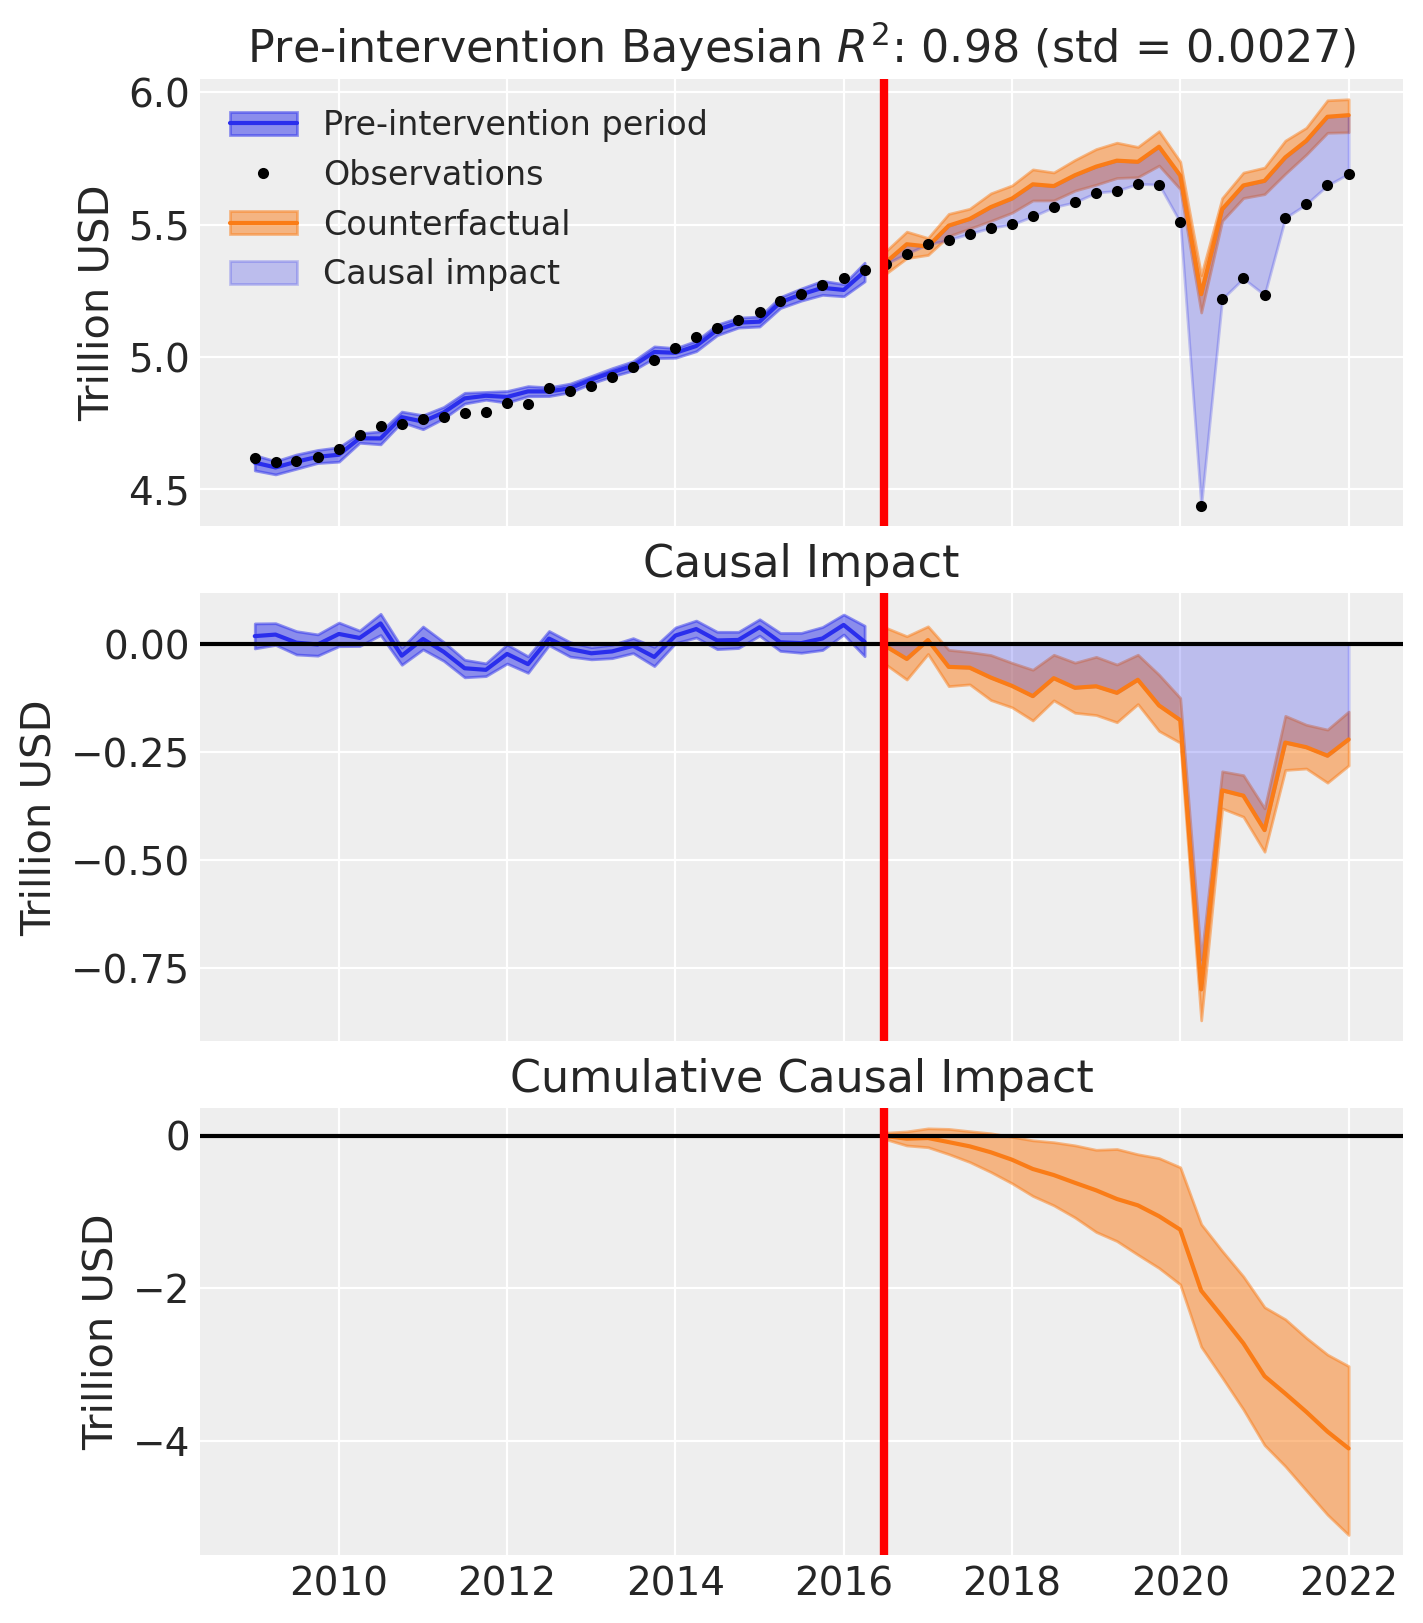

In [12]:
az.style.use("arviz-darkgrid")

fig, ax = result.plot(plot_predictors=False)

for i in [0, 1, 2]:
    ax[i].set(ylabel="Trillion USD")

In [13]:
result.summary()

================================SyntheticControl================================
Control units: ['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Luxemburg', 'Netherlands', 'New_Zealand', 'Norway', 'Sweden', 'Switzerland']
Treated unit: UK
Model coefficients:
    Australia    0.12, 94% HDI [0.0086, 0.27]
    Austria      0.046, 94% HDI [0.0013, 0.15]
    Belgium      0.052, 94% HDI [0.0016, 0.17]
    Canada       0.038, 94% HDI [0.0025, 0.085]
    Denmark      0.085, 94% HDI [0.0031, 0.23]
    Finland      0.041, 94% HDI [0.0015, 0.14]
    France       0.031, 94% HDI [0.0011, 0.1]
    Germany      0.026, 94% HDI [0.00096, 0.086]
    Iceland      0.15, 94% HDI [0.075, 0.23]
    Luxemburg    0.049, 94% HDI [0.0011, 0.16]
    Netherlands  0.048, 94% HDI [0.0021, 0.16]
    New_Zealand  0.062, 94% HDI [0.0015, 0.19]
    Norway       0.082, 94% HDI [0.0076, 0.17]
    Sweden       0.1, 94% HDI [0.039, 0.16]
    Switzerland  0.065, 94% HDI [0.

## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect with key statistics. The `effect_summary()` method provides a decision-ready report with average and cumulative effects, HDI intervals, tail probabilities, and relative effects. This provides a comprehensive summary without manual post-processing.


In [14]:
# Generate effect summary for the full post-period
stats = result.effect_summary()
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-0.178323,-0.179121,-0.227586,-0.127143,0.0,-3.164222,-4.005843,-2.278178
cumulative,-4.101438,-4.119792,-5.234484,-2.924293,0.0,-3.164222,-4.005843,-2.278178


In [15]:
# View the prose summary
print(stats.text)

Post-period (2016-07-01 00:00:00 to 2022-01-01 00:00:00), the average effect was -0.18 (95% HDI [-0.23, -0.13]), with a posterior probability of an increase of 0.000. The cumulative effect was -4.10 (95% HDI [-5.23, -2.92]); probability of an increase 0.000. Relative to the counterfactual, this equals -3.16% on average (95% HDI [-4.01%, -2.28%]).


In [16]:
# You can also analyze a specific time window, e.g., the first year after Brexit
stats_window = result.effect_summary(
    window=(pd.to_datetime("2016-06-24"), pd.to_datetime("2017-06-24"))
)
stats_window.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-0.021407,-0.021822,-0.064357,0.021860,0.1635,-0.393064,-1.17724,0.406281
cumulative,-0.085627,-0.087289,-0.257429,0.087441,0.1635,-0.393064,-1.17724,0.406281


## Understanding the Convex Hull Assumption

The synthetic control method relies on a fundamental mathematical constraint that is important to understand.

### The Mathematical Constraint

In synthetic control, we construct a counterfactual as a weighted combination of control units:

$$\mu_t = \sum_{i=1}^{n} \beta_i x_{it}$$

where the weights satisfy:
- **Non-negativity**: $\beta_i \geq 0$ for all $i$
- **Sum-to-one**: $\sum_{i=1}^{n} \beta_i = 1$

These constraints mean our synthetic control is a **convex combination** of the control units. By definition, a convex combination can only produce values within the **convex hull** of the input points—mathematically, it cannot extrapolate beyond the range of the control units.

### What This Means in Practice

At each time point, the synthetic control value must lie between the minimum and maximum of the control units:

$$\min_i(x_{it}) \leq \mu_t \leq \max_i(x_{it})$$

This is a **necessary condition** for the method to work. If the treated unit's pre-intervention values fall outside this range—either consistently above all controls or consistently below all controls—no valid convex combination can match the treated trajectory.

### Checking the Assumption

CausalPy automatically checks this assumption when you fit a synthetic control model. Let's visualize what this looks like with our Brexit data:

/var/folders/r0/nf1kgxsx6zx3rw16xc3wnnzr0000gn/T/ipykernel_84415/2891153136.py:83: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


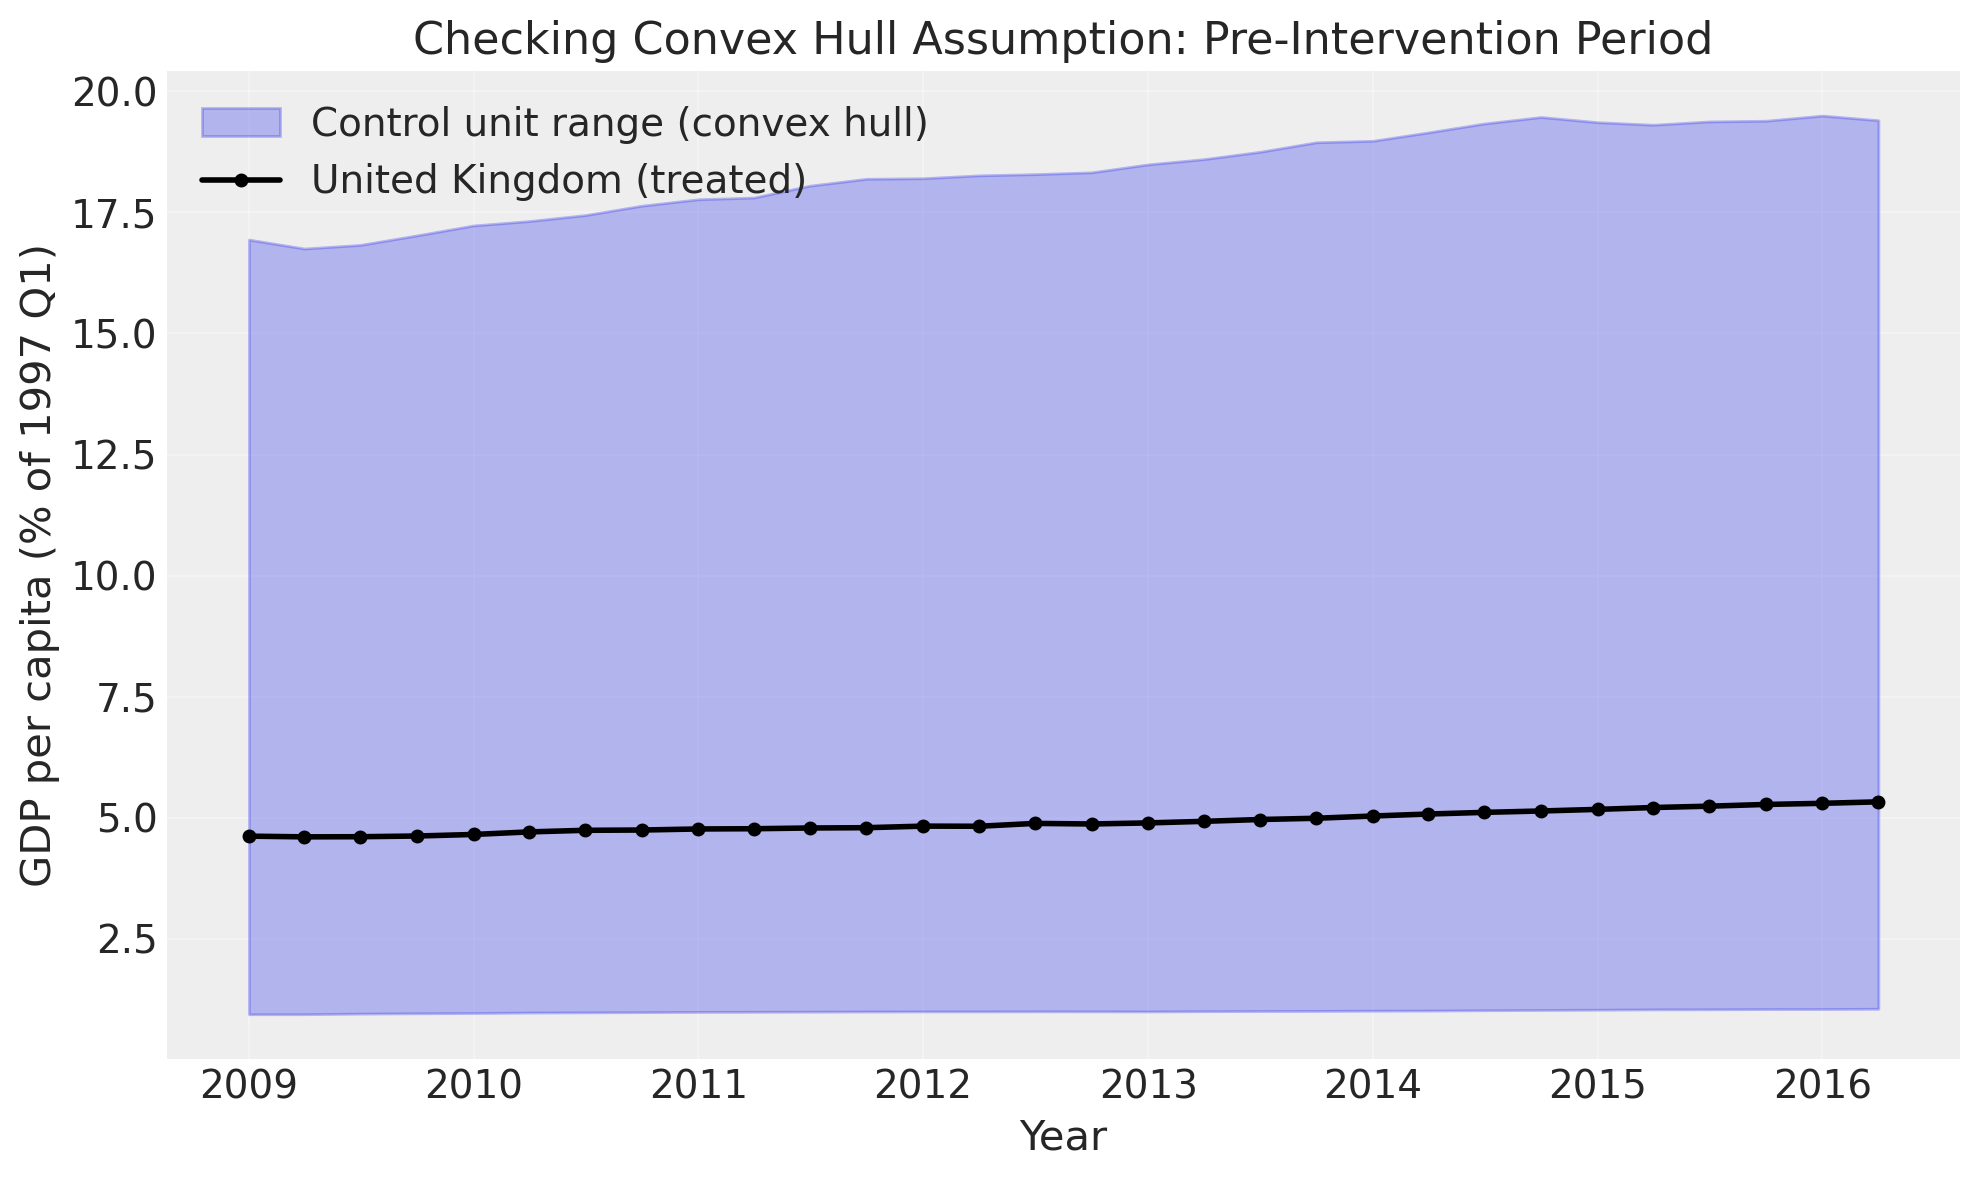

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Extract pre-intervention data
pre_data = df[df.index < treatment_time]

# Get control and treated series
control_countries = [
    "Australia",
    "Belgium",
    "Canada",
    "Denmark",
    "France",
    "Germany",
    # "Italy",
    # "Japan",
    "Netherlands",
    "Norway",
    "Sweden",
    "Switzerland",
    # "USA",
]
treated_country = "UK"

# Calculate control envelope
control_min = pre_data[control_countries].min(axis=1)
control_max = pre_data[control_countries].max(axis=1)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot control envelope as shaded region
ax.fill_between(
    pre_data.index,
    control_min,
    control_max,
    alpha=0.3,
    color="C0",
    label="Control unit range (convex hull)",
)

# Plot treated series
ax.plot(
    pre_data.index,
    pre_data[treated_country],
    "ko-",
    linewidth=2,
    markersize=4,
    label="United Kingdom (treated)",
)

# Highlight any violations
above = pre_data[treated_country] > control_max
below = pre_data[treated_country] < control_min

if above.any():
    ax.scatter(
        pre_data.index[above],
        pre_data[treated_country][above],
        color="red",
        s=100,
        marker="x",
        zorder=5,
        label="Points above control range",
    )

if below.any():
    ax.scatter(
        pre_data.index[below],
        pre_data[treated_country][below],
        color="orange",
        s=100,
        marker="x",
        zorder=5,
        label="Points below control range",
    )

ax.set_xlabel("Year")
ax.set_ylabel("GDP per capita (% of 1997 Q1)")
ax.set_title("Checking Convex Hull Assumption: Pre-Intervention Period")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
n_violations = above.sum() + below.sum()
if n_violations > 0:
    print(f"⚠️  Warning: {n_violations} time points outside control range")
    print(
        f"   - {above.sum()} points above control range ({100 * above.sum() / len(pre_data):.1f}%)"
    )
    print(
        f"   - {below.sum()} points below control range ({100 * below.sum() / len(pre_data):.1f}%)"
    )
else:
    print("✓ Convex hull assumption satisfied: All treated values within control range")

✓ Convex hull assumption satisfied: All treated values within control range


### Interpreting the Results

For this Brexit analysis:

- **Good fit**: The UK's pre-Brexit GDP trajectory lies mostly within the range of control countries, suggesting the convex hull assumption is reasonably satisfied.
- **High R²**: The strong pre-intervention fit (R² ≈ 0.97) we saw earlier confirms that a convex combination of control countries can indeed approximate the UK's trajectory.

### When the Assumption is Violated

If you see many points outside the shaded region, this indicates potential problems:

1. **Poor counterfactual quality**: The synthetic control cannot accurately match the treated unit's pre-intervention trajectory
2. **Biased effect estimates**: The treatment effect estimates may be unreliable
3. **Invalid inference**: Confidence/credible intervals may not have correct coverage

### What to Do if Violated

Several alternatives exist when the convex hull assumption is violated:

1. **Add more diverse control units**: Include countries/units with different characteristics that better span the range of the treated unit

2. **Consider use of Augmented Synthetic Control Method**: This method {cite:p}`benmichael2021augmented` relaxes the convex hull assumption

3. **Consider use of {term}`Comparative interrupted time-series`**: With an intercept term, this approach can handle systematic differences in levels between treated and control units

### Key Takeaway

The {term}`convex hull condition` is a fundamental requirement for synthetic control methods. Always check this assumption using visualizations like the one above or by examining the warnings CausalPy provides. For more details, see {cite:t}`abadie2010synthetic`.

## Custom priors

The analysis above is all based upon the default priors for the `WeightedSumFitter` class. But this might not always be appropriate. In particular the default Priors are [Dirichlet distributed](https://en.wikipedia.org/wiki/Dirichlet_distribution) with an alpha parameter of 1. This corresponds to a uniform prior over the simplex.

But we might have different prior beliefs. For example, we might think that some control units will play a larger role and some control units will be irrelevant. In which case, we could use as less concentrated prior, such as $\mathrm{Dirichlet}(0.1)$.

We can do this in the code below.

In [19]:
n_control_units = len(other_countries)

result_custom = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=other_countries,
    treated_units=[target_country],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs=sample_kwargs,
        priors={
            "beta": Prior(
                "Dirichlet",
                a=0.1 * np.ones(n_control_units),
                dims=["treated_units", "coeffs"],
            ),
        },
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat

The main results plot shows only minor differences in terms of fitting.

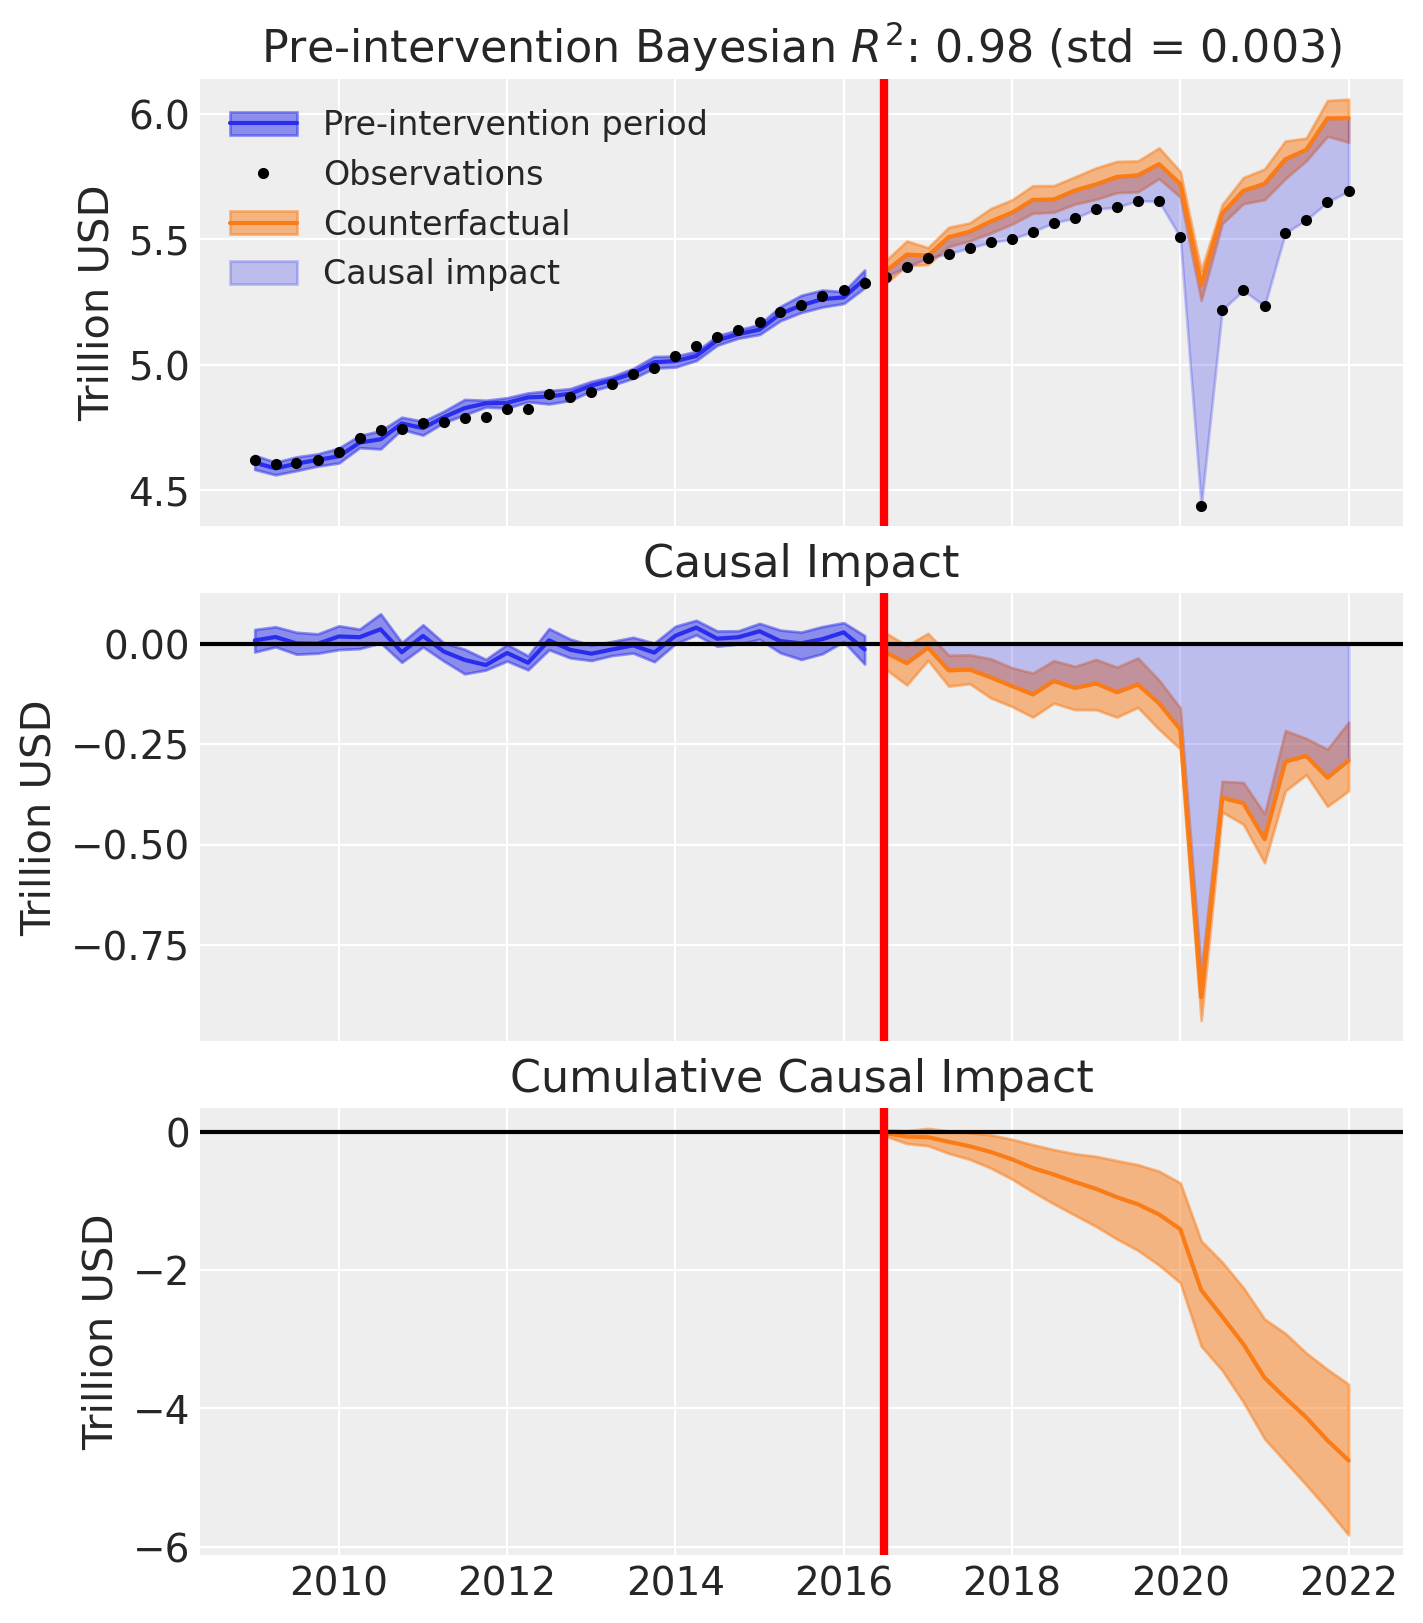

In [20]:
fig, ax = result_custom.plot(plot_predictors=False)

for i in [0, 1, 2]:
    ax[i].set(ylabel="Trillion USD")

We can also examine the effect of changing the Dirichlet prior on the posterior distribution of weights. TWe can see that the custom prior of $\mathrm{Dirichlet}(0.1)$ results in more sparse weights over control countries. The posterior of many countries are more concentrated near zero (e.g. Austria, Canada, Germany, etc), while others have increased in importance (e.g. Denmark, and Australia).

This is a rich area for discussion, but the key point is that users can define their own prior beliefs about the weights in the synthetic control model. There are some benefits from having 'sparsifying' priors in that they can help identify a smaller set of key control units that are most relevant to constructing the synthetic control.

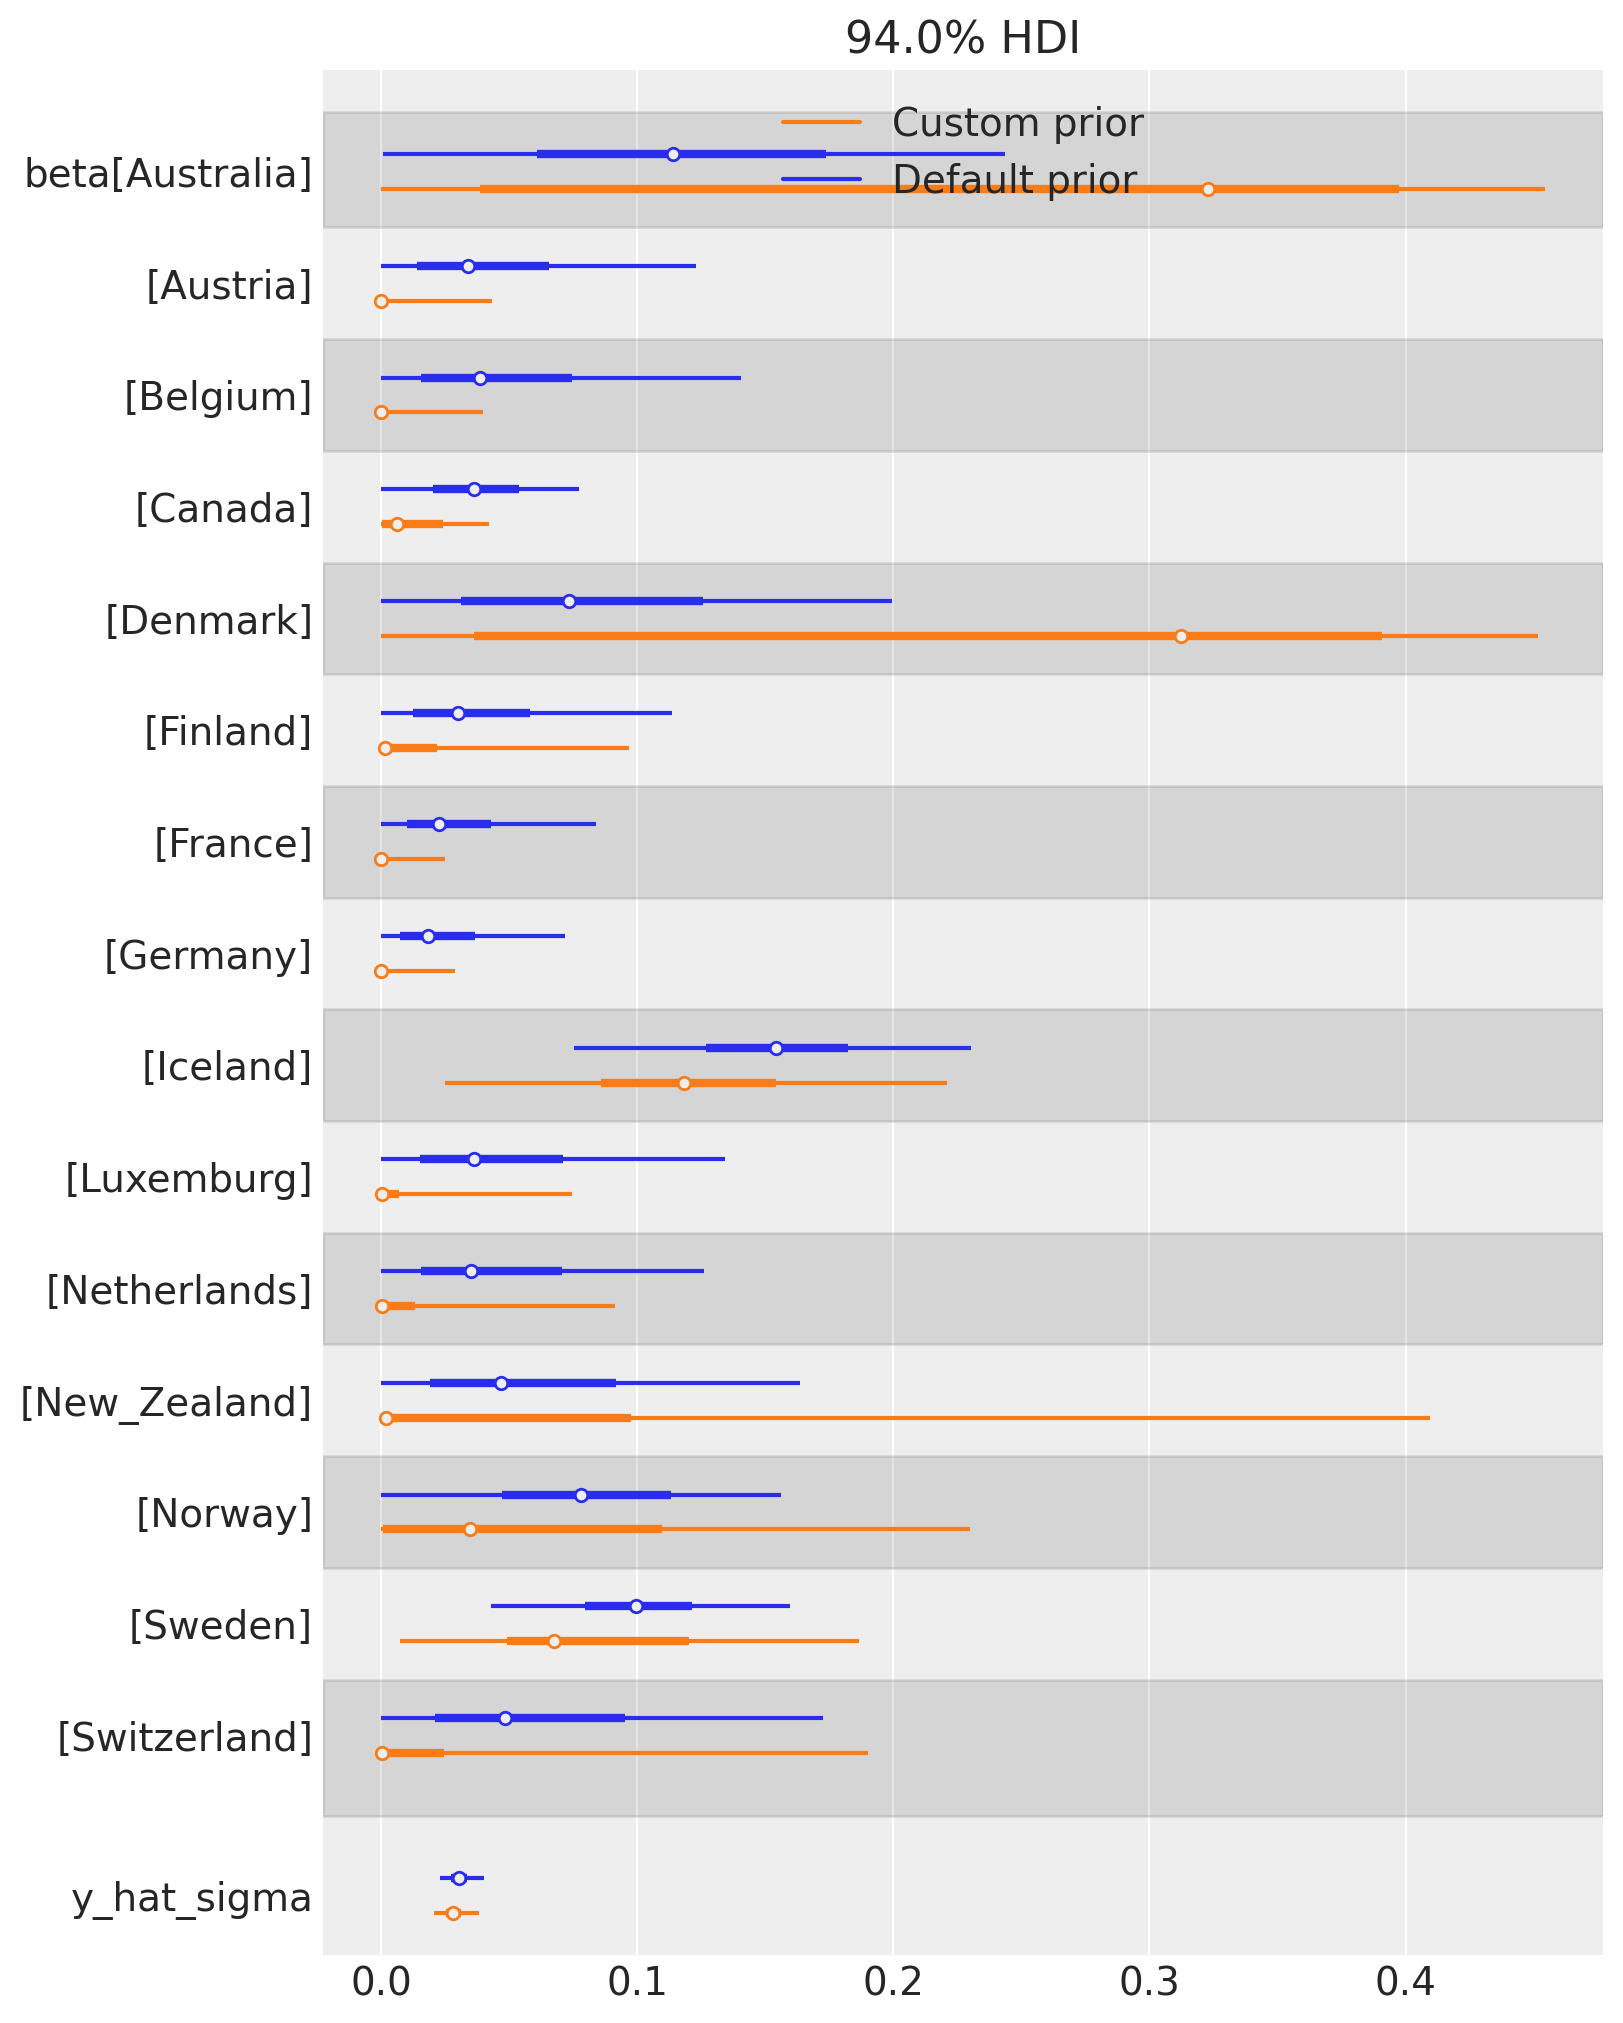

In [21]:
az.plot_forest(
    [result.idata, result_custom.idata],
    model_names=["Default prior", "Custom prior"],
    var_names=["beta", "y_hat_sigma"],
    combined=True,
    figsize=(8, 10),
);

## References
:::{bibliography}
:filter: docname in docnames
:::